<a href="https://colab.research.google.com/github/Moshood-O/Hamoye-Internship/blob/master/StageD_Planets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook contains code used to solve the "Planet: Understanding the Amazon from space" competition hosted on kaggle

# Import necessary dependencies

In [1]:
from os import listdir

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

from tensorflow import keras
import tensorflow as tf

import cv2

from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.optimizers import Nadam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess, VGG16
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess, VGG19

from tqdm import tqdm

import gc

# Fetch the data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moshoodolaleke","key":"11376013675aa6c6ee080d7a27d4fb37"}'}

**Define a function used to download the data from kaggle**

In [3]:
def fetch_planet_data():
    !pip uninstall -y kaggle
    !pip install --upgrade pip
    !pip install kaggle==1.5.6
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d nikitarom/planets-dataset
    !mkdir planets_dataset
    !unzip planets-dataset -d planets_dataset

In [4]:
%%capture
fetch_planet_data()

# Read and preprocess the data containing the training classes

In [2]:
train_classes = pd.read_csv("/content/planets_dataset/planet/planet/train_classes.csv")
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


**The classes (tags) are space-delineated so they are converted to lists**

In [3]:
train_classes["tags"] = train_classes["tags"].map(lambda x: x.split(" "))
train_classes.head()

,image_name,tags
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"


**The classes are then one-hot encoded**

In [4]:
encoder = MultiLabelBinarizer()
tags_df = pd.DataFrame(encoder.fit_transform(train_classes.tags), columns=encoder.classes_)
train_df = pd.concat([train_classes, tags_df], axis=1)
train_df.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,"[haze, primary]",0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,"[agriculture, clear, primary, water]",1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,"[clear, primary]",0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,"[agriculture, clear, habitation, primary, road]",1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


**Visualize the distribution of the classes**

In [5]:
num_tags = len(encoder.classes_)
num_tags

17

There are 17 different classes

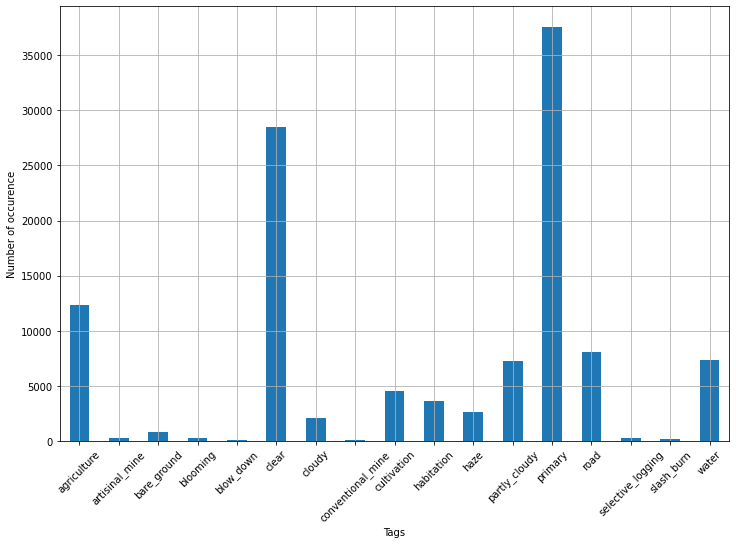

In [6]:
# create a series holder for the count of each class
tag_counts = pd.Series(0, index=encoder.classes_)

# get count of each class
for tags in train_df.tags:
    for tag in tags:
        tag_counts[tag] += 1

# plot the distribution of the classes
tag_counts.plot.bar(figsize=(12, 8), grid=True)
plt.xticks(rotation=45)
plt.xlabel("Tags")
plt.ylabel("Number of occurence")
plt.show()

**From the plot above, it is seen that the commonest areas are primary rainforests suggesting that those are densely covered by trees. Areas that are clear, Areas used for agriculture (which contributes to deforestation) and water bodies are also quite common**

**Drop the `tags` column as that is no longer needed**

In [7]:
train_df.drop("tags", axis=1, inplace=True)

Delete unsused variables to clear up space due to memory

In [8]:
del tags_df, train_classes

gc.collect()

4253

# Load the training images

In [9]:
train_images = []
for image in tqdm(train_df.image_name.values, miniters=1000):
    train_images.append(cv2.resize(cv2.imread(f"/content/planets_dataset/planet/planet/train-jpg/{image}.jpg"), (64, 64)))
train_images = np.array(train_images, dtype="float16")

100%|██████████| 40479/40479 [01:03<00:00, 638.94it/s]


# Prepare the data to be fed into the models

In [10]:
def prepare_data(train_images=train_images, train_df=train_df):
    X, Y = train_images, train_df.iloc[:, 1:].values.astype("float16")
    X, Y = shuffle(X, Y, random_state=42)
    train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

    # del train_images, train_df
    # gc.collect()

    return (X, Y), (train_X, val_X, train_Y, val_Y)

In [11]:
(X, Y), (train_X, val_X, train_Y, val_Y) = prepare_data()

# Model Development and Evaluation

**Define a custom f-beta metric function for model evaluation**

In [12]:
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

**Define model architecture**

In [13]:
def model(base_model, learning_rate, metric=fbeta):
    # create a Sequential model and add the layers of a base model as weel as a classifier layer to it
    model = Sequential([
                        base_model,
                        Flatten(),
                        Dense(num_tags, activation="sigmoid")
    ])

    # Freeze the layers of the base model to retain their weights
    for layer in base_model.layers:
        layer.trainable = False

    # Define optimizer
    optimizer = Nadam(learning_rate=learning_rate)

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[fbeta])

    return model


**Define a function to fine-tune the model if necessary**

In [14]:
def fine_tune(base_model, model, learning_rate, num_layers=-1):
    
    # if num_layers = -1, unfreeze all layers of the base model so they can be
    # trained. If another number (n), unfreeze only the top n layers of the base
    # model
    if num_layers == -1:
        layers_to_train = base_model.layers
    else:
        layers_to_train = base_model.layers[-num_layers:]
    
    for layer in layers_to_train:
        layer.trainable = True
    
    # define optimizer
    optimizer = Nadam(learning_rate=learning_rate)
    
    # compile the fine-tuned model
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[fbeta])

    return model


**Define a function that returns iterators that pass data in batches to the model for training**

In [15]:
def data_iterators(model_preprocess):
    
    # preprocess the input images to the required format for vgg19 implementation
    processed_train_X, processed_val_X = model_preprocess(train_X), model_preprocess(val_X)

    # create data generators and also implement data augmentaion which introduces
    # random transformations to the images. This is done to improve the
    # generalization of the model
    train_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    val_generator = ImageDataGenerator()
    train_iterator = train_generator.flow(processed_train_X, train_Y, batch_size=64)
    val_iterator = val_generator.flow(processed_val_X, val_Y, batch_size=64)

    return train_iterator, val_iterator


**Implement callbacks for training**

In [16]:
def callbacks(validation=True):
    # implement an early stopping callback to prevent overfitting
    
    early_stopping = EarlyStopping(monitor="loss", patience=5,
                                    restore_best_weights=True)
    
    # implement performance scheduling for tuning the learning rate
    scheduler = ReduceLROnPlateau(monitor="loss", factor=0.1, patience=2,
                                  min_lr=1e-7, cooldown=0)
    return [early_stopping, scheduler]

In [17]:
base_model = VGG19(include_top=False, input_shape=(64, 64, 3)) # define the base model using all layers except the top

In [18]:
train_iterator, val_iterator = data_iterators(model_preprocess=vgg19_preprocess) # get the data iterators

In [19]:
model = model(base_model, learning_rate=0.001) # define the model

In [20]:
# train the model
history = model.fit(train_iterator, validation_data=val_iterator, steps_per_epoch=len(train_iterator),
          validation_steps=len(val_iterator), epochs=10, callbacks=[callbacks()])

Epoch 1/10
506/506 [==============================] - 57s 112ms/step - loss: 0.2272 - fbeta: 0.7957 - val_loss: 0.1913 - val_fbeta: 0.8136
Epoch 2/10
506/506 [==============================] - 55s 109ms/step - loss: 0.1734 - fbeta: 0.8225 - val_loss: 0.1750 - val_fbeta: 0.8278
Epoch 3/10
506/506 [==============================] - 55s 108ms/step - loss: 0.1661 - fbeta: 0.8247 - val_loss: 0.1744 - val_fbeta: 0.8263
Epoch 4/10
506/506 [==============================] - 55s 109ms/step - loss: 0.1635 - fbeta: 0.8264 - val_loss: 0.1750 - val_fbeta: 0.8217
Epoch 5/10
506/506 [==============================] - 54s 107ms/step - loss: 0.1632 - fbeta: 0.8278 - val_loss: 0.1785 - val_fbeta: 0.8335
Epoch 6/10
506/506 [==============================] - 55s 108ms/step - loss: 0.1493 - fbeta: 0.8335 - val_loss: 0.1624 - val_fbeta: 0.8309
Epoch 7/10
506/506 [==============================] - 55s 108ms/step - loss: 0.1458 - fbeta: 0.8339 - val_loss: 0.1581 - val_fbeta: 0.8342
Epoch 8/10
506/506 [=======

**Visualize the trajectories for the losses and fbeta scores**

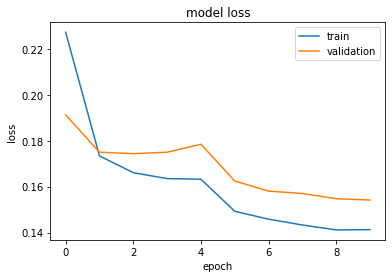

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

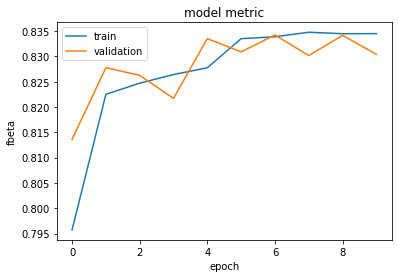

In [22]:
plt.plot(history.history["fbeta"])
plt.plot(history.history['val_fbeta'])
plt.title('model metric')
plt.ylabel('fbeta')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

**From the plots above, it can be seen that the metrics and losses have not yet reached an extrema so incresing the number of epochs and fine-tuning the model by training more of the base model's layers might improve the accuracy**

In [23]:
model = fine_tune(base_model, model, learning_rate=0.0001) # Fine-tune the model

In [24]:
# Train the fine-tuned model
history = model.fit(train_iterator, validation_data=val_iterator, steps_per_epoch=len(train_iterator),
          validation_steps=len(val_iterator), epochs=50, callbacks=[callbacks()])

Epoch 1/50
506/506 [==============================] - 116s 230ms/step - loss: 0.1328 - fbeta: 0.8378 - val_loss: 0.1253 - val_fbeta: 0.8527
Epoch 2/50
506/506 [==============================] - 115s 227ms/step - loss: 0.1129 - fbeta: 0.8639 - val_loss: 0.1132 - val_fbeta: 0.8689
Epoch 3/50
506/506 [==============================] - 115s 227ms/step - loss: 0.1077 - fbeta: 0.8719 - val_loss: 0.1119 - val_fbeta: 0.8651
Epoch 4/50
506/506 [==============================] - 115s 227ms/step - loss: 0.1047 - fbeta: 0.8768 - val_loss: 0.1064 - val_fbeta: 0.8791
Epoch 5/50
506/506 [==============================] - 115s 227ms/step - loss: 0.1020 - fbeta: 0.8794 - val_loss: 0.1031 - val_fbeta: 0.8794
Epoch 6/50
506/506 [==============================] - 115s 227ms/step - loss: 0.1005 - fbeta: 0.8809 - val_loss: 0.1093 - val_fbeta: 0.8824
Epoch 7/50
506/506 [==============================] - 115s 227ms/step - loss: 0.0986 - fbeta: 0.8838 - val_loss: 0.1082 - val_fbeta: 0.8732
Epoch 8/50
506/506 [

**Visualize learning trajectories**

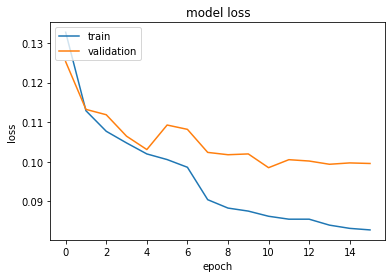

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

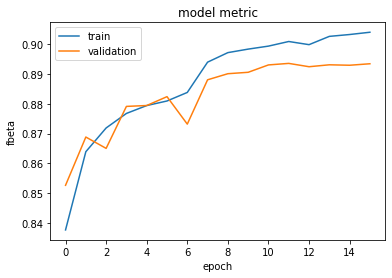

In [26]:
plt.plot(history.history["fbeta"])
plt.plot(history.history['val_fbeta'])
plt.title('model metric')
plt.ylabel('fbeta')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

**The performance of the model during this training yielded much better results than the first training**

**Seeing how we have many classes, having an fbeta threshold of 0.5 could slightly diminish performance hence it would be reasonable to determine the optimal fbeta threshold for each class to make better predictions.**

In [27]:
def get_optimal_threshold(true_label, predicted_label, iterations = 100):
    
    # use sklearn's fbeta_score function instead of the one defined above using
    # keras' backend due to incompatible data types
    def fbeta(true_label, predicted_label):
        return fbeta_score(true_label, predicted_label, beta=2, average='samples')

    best_threshold = [0.2] * num_tags # set a best threshold holder
    
    # iterate through the various tags   
    for t in range(num_tags):
        best_fbeta = 0 # temporary fbeta score
        temp_threshold = [0.2] * num_tags # temporary threshold
        
        # Make a 100 iterations for each tag to ensure convergence
        # Keep updating the best threshold until a maximum fbeta is achieved
        for i in range(iterations):
            temp_value = i / float(iterations)
            temp_threshold[t] = temp_value
            temp_fbeta = fbeta(true_label, predicted_label > temp_threshold)
            if  temp_fbeta> best_fbeta:
                best_fbeta = temp_fbeta
                best_threshold[t] = temp_value
    return best_threshold

In [28]:
val_X = vgg19_preprocess(val_X) # preprocess the validation images
val_predictions = model.predict(val_X) # make predictions on the validation 

get optimal thresholds
thresholds = get_optimal_threshold(val_Y, val_predictions)

delete unused variables to save up space
del val_predictions, train_X, val_X, train_Y, val_Y
gc.collect()

677

**Let's now train the model on the whole dataset**

In [31]:
X = vgg19_preprocess(X) # preprocess the entire training images

# Obtain a data iterator for the entire dataset
train_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
train_iterator = train_generator.flow(X, Y, batch_size=64)

In [32]:
model = fine_tune(base_model, model, learning_rate=0.0001) # define model

In [34]:
history = model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=20) # Train the model

Epoch 1/20
633/633 [==============================] - 136s 215ms/step - loss: 0.1000 - fbeta: 0.8821
Epoch 2/20
633/633 [==============================] - 135s 214ms/step - loss: 0.0980 - fbeta: 0.8852
Epoch 3/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0963 - fbeta: 0.8880
Epoch 4/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0951 - fbeta: 0.8892
Epoch 5/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0943 - fbeta: 0.8899
Epoch 6/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0936 - fbeta: 0.8913
Epoch 7/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0926 - fbeta: 0.8915
Epoch 8/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0918 - fbeta: 0.8934
Epoch 9/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0908 - fbeta: 0.8948
Epoch 10/20
633/633 [==============================] - 135s 213ms/step - loss: 0.0901 - fbe

**Save the model**

In [35]:
model.save("final_vgg19_model.h5")

# Predictions

**Load the model**

In [36]:
model = keras.models.load_model("/content/final_vgg19_model.h5", custom_objects={"fbeta": fbeta})

## Read test images

In [39]:
folder = "/content/planets_dataset/planet/planet/test-jpg"
test_images1 = []
test_images1_names = []
for image in tqdm(listdir(folder), miniters=1000):
    test_images1.append(cv2.resize(cv2.imread(folder + "/" + image), (64, 64)))
    test_images1_names.append(image.split(".")[0])

folder = "/content/planets_dataset/test-jpg-additional/test-jpg-additional"
test_images2 = []
test_images2_names = []
for image in tqdm(listdir(folder), miniters=1000):
    test_images2.append(cv2.resize(cv2.imread(folder + "/" + image), (64, 64)))
    test_images2_names.append(image.split(".")[0])

100%|██████████| 20522/20522 [00:39<00:00, 522.03it/s]


**Carry out some processing on the images**

In [40]:
test_X = np.array(test_images1 + test_images2, dtype="float16") # combine the test images from both sources

# get the corresponding image names of the test images
test_names = test_images1_names + test_images2_names

# delete unused variables
del test_images1, test_images2, test_images1_names, test_images2_names
gc.collect()

306

## Make predictions

In [41]:
test_X = vgg19_preprocess(test_X) # preprocess the test images

# make predictions based on the earlier-defined thresholds
predictions = (model.predict(test_X) > thresholds).astype("int32")

**Convert the numerical predictions to their appropriate labels**

In [43]:
tags = train_df.columns[1:] # get the tags

labelled_predictions = []

# iterate through the predictions
for prediction in predictions:
    labels = []

    # iterate throuh the tags
    for i in range(len(tags)):
        # add the appropriate tag if prediction is 1
        if prediction[i] == 1:
            labels.append(tags[i])
    labelled_predictions.append(labels)
labelled_predictions[0]

['clear', 'cloudy', 'haze', 'primary']

**Convert the list of tags to space-delineated strings**

In [44]:
processed_predictions = list(map(lambda x: (" ").join(x), labelled_predictions))

In [45]:
# convert the predictions to a dictionary
pred_dict = {"image_name": test_names, "tags": processed_predictions}

# create a datframe of the predictions
submission = pd.DataFrame(pred_dict)

# sort by image names in alphabetical order
submission.sort_values(by="image_name", inplace=True)
submission.reset_index(drop=True, inplace=True) # reset index
submission.head()

,image_name,tags
0,file_0,clear primary
1,file_1,agriculture cultivation habitation partly_clou...
2,file_10,agriculture haze partly_cloudy primary road water
3,file_100,agriculture clear primary road water
4,file_1000,agriculture clear primary


**Create a submission csv file**

In [46]:
submission.to_csv("planets_final_submission.csv", index=False)

The submission gave a private score of 0.91688 and public score of 0.91767 with a rank between positions 353 and 354 on the private leaderboard.

# Notebook by: OLALEKE Moshood A.